In [76]:
import cv2
import dlib
from PIL import Image
import imutils
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

In [77]:
# Displayinh the number of GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [75]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

In [4]:
# load a test image, resize it, and convert it to grayscale
def load_image(path, show=False, gray_show=False):
    test_image = cv2.imread(path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    test_image = imutils.resize(test_image, width=500)
    gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

    if show:
        plt.imshow(test_image)
        plt.show()
        if gray_show:
            plt.imshow(gray, cmap='gray')
            plt.show()
    return test_image, gray

def detect_faces(face_detector, gray, img, scale_factor, frame_num, show_multi_faces = False):
    detections = haar_cascade.detectMultiScale(gray, scaleFactor=scale_factor, minNeighbors=5, minSize=(150, 150), flags=cv2.CASCADE_SCALE_IMAGE)
    #Checking if there are more than 1 detected faces
    if len(detections) > 1:
        print('multiple faces', frame_num)
        if detections[0][2] > detections[1][2]:
            face = detections[0]
            other = detections[1]
        else:
            face = detections[1]
            other = detections[0]
        if show_multi_faces:
            print('largest and chosen face')
            fX, fY, fW, fH = face[0],face[1], face[2], face[3]
            plt.imshow(gray[fY:fY + fH, fX:fX + fW], cmap='gray')
            plt.show()
            print('not chosen face')
            fX, fY, fW, fH = other[0], other[1], other[2], other[3]
            plt.imshow(gray[fY:fY + fH, fX:fX + fW], cmap='gray')
            plt.show()
    elif len(detections) == 1:
        face = detections[0]
    # if no face detected
    elif len(detections) == 0:
        print('No face detected', frame_num)
        return False
    fX, fY, fW, fH = face[0], face[1], face[2], face[3]
    face_img = Image.fromarray(img[fY:fY + fH, fX:fX + fW])
    face_img = face_img.resize((224, 224))
    #face_img.show()
    return face_img

In [5]:
def get_face(path, face_detector, model, scale_factor):
    test_img, gray = load_image(path, show=False)
    face = detect_faces(face_detector, gray, test_img, scale_factor, 1, show_multi_faces=False)

    if not face:
        print("No face detected")
        return False

    face_array = np.asarray(face)
    # pixels = face_array.astype('float32')
    # samples = np.expand_dims(pixels, axis=0)
    # samples = preprocess_input(samples, version=2)
    # embedding = model.predict(samples, verbose=0)
    # embeddings.append(embedding[0])
    return tf.convert_to_tensor(face_array, dtype=tf.uint8)

In [60]:
# haar Cascade path
cascade_path = '../models/haarcascade_frontalface_default.xml'
# create haar cascade
haar_cascade = cv2.CascadeClassifier(cascade_path)
face_detector = 'haar'

frame_start = 0
frame_end = 46000
frames = range(frame_start, frame_end + 1)

scale_factor = 1.04

folder_path = '../frames/P11410/normal/frame'

In [78]:
import gc
gc.collect()

26801

In [62]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=100)])
#   except RuntimeError as e:
#     print(e)
    
print("GPU is set")

GPU is set


In [41]:
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [79]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [42]:
print('test')

test


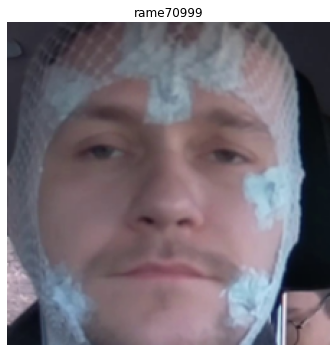

In [64]:
frame = 70999
path = folder_path + str(frame) + '.jpg'
face = get_face(path, face_detector, model, scale_factor)

plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.imshow(face)
ax.set_title(path[-13:-4])
ax.axis('off')
plt.tight_layout()
plt.show()

In [65]:
import gc
gc.collect()
baseline = tf.zeros(shape=(224,224,3), dtype=tf.uint8)

In [66]:
gc.collect()

m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    print(input_x.dtype, baseline_x.dtype)
    delta = input_x - baseline_x
    delta = tf.cast(delta, tf.float32)
    baseline_x = tf.cast(baseline_x, tf.float32)
    print(baseline_x.dtype, delta.dtype, alphas_x.dtype)
    images = baseline_x +  alphas_x * delta
    print(images.dtype)
    return images

gc.collect()
interpolated_images = interpolate_images(baseline=baseline, image=face, alphas=alphas)
interpolated_images_int = tf.cast(interpolated_images, tf.uint8)


<dtype: 'uint8'> <dtype: 'uint8'>
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
<dtype: 'float32'>


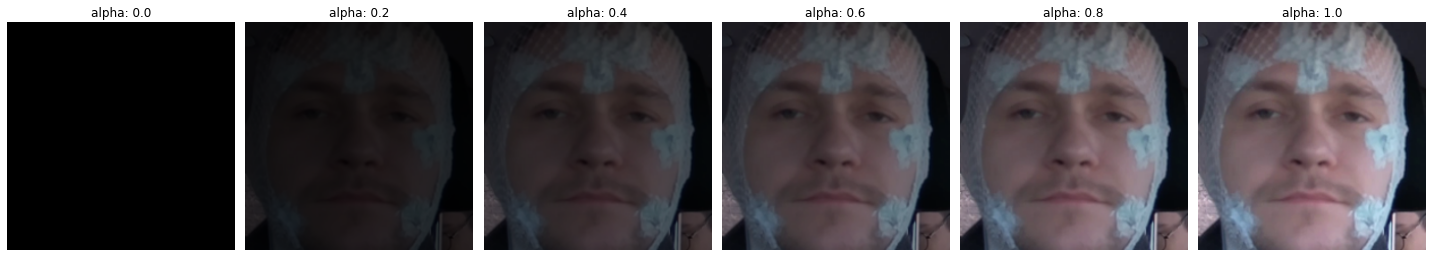

In [67]:
gc.collect()

fig = plt.figure(figsize=(20, 20))
i = 0
for alpha, image in zip(alphas[0::10], interpolated_images_int[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout();

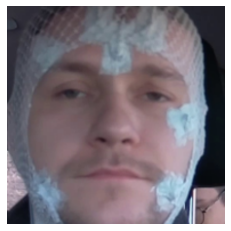

[1657    3  465] tf.Tensor([0.8985987  0.03621702 0.02412357], shape=(3,), dtype=float32)


In [68]:
def top_k_predictions(img, k=3):
    image = tf.expand_dims(img, 0)
    predictions = model(image)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
    top_labels = np.array(tuple(top_idxs[0]) )
    return top_labels, top_probs[0]

#Display the image with top 3 prediction from the model
plt.imshow(face)
plt.axis('off')
plt.show()
pred_label, pred_prob = top_k_predictions(face)
print(pred_label, pred_prob)
target_class = pred_label[0]

In [69]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)
path_gradients = compute_gradients(images=interpolated_images, target_class_idx=target_class)

In [70]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [71]:
def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=1):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    # Initialize TensorArray outside loop to collect gradients.    
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    
    # Iterate alphas range and batch computation for speed, memory #efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]
        
    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)
    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch, target_class_idx=target_class_idx)
    
    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
  
    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()
    # 4. Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)
    # 5. Scale integrated gradients with respect to input.
    image = tf.cast(image, tf.float32)
    baseline = tf.cast(baseline, tf.float32)
    
    print(image.dtype, baseline.dtype, avg_gradients.dtype)
    integrated_gradients = (image - baseline) * avg_gradients
    return integrated_gradients
ig_attributions = integrated_gradients(baseline=baseline, image=face, target_class_idx=target_class, m_steps=283)

<dtype: 'uint8'> <dtype: 'uint8'>
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>


<dtype: 'uint8'> <dtype: 'uint8'>
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>


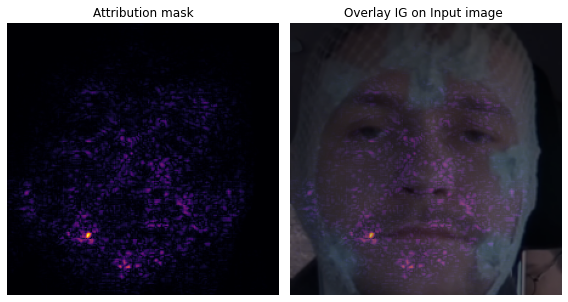

In [72]:
def plot_img_IG(baseline, image, target_class_idx, m_steps=50, cmap=None, overlay_alpha=0.4):
    attributions = integrated_gradients(baseline=baseline, image=image, target_class_idx=target_class_idx, m_steps=m_steps)
    #print(attributions)
    #attributions = tf.cast(attributions, tf.int8)
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
    fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=   (8, 8))
    axs[0, 0].set_title('Attribution mask')
    axs[0, 0].imshow(attribution_mask, cmap=cmap)
    axs[0, 0].axis('off')
    axs[0, 1].set_title('Overlay IG on Input image ')
    axs[0, 1].imshow(attribution_mask, cmap=cmap)
    axs[0, 1].imshow(image, alpha=overlay_alpha)
    axs[0, 1].axis('off')
    plt.tight_layout()
    plt.savefig('../figures/igg_sub10_normal.jpg')
    return fig
_ = plot_img_IG(image=face, baseline=baseline, target_class_idx=target_class, m_steps=240, cmap=plt.cm.inferno, overlay_alpha=0.4)